In [1]:
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import numpy as np
import string
from gensim import corpora
import gensim
from nltk.corpus import words
from gensim.models import LdaModel, LsiModel, Word2Vec, CoherenceModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from collections import defaultdict
from spacy.lang.en import STOP_WORDS
from pprint import pprint

In [ ]:
# Topic coherence and its graph, top topics

In [2]:
# configure number of worker for multicore
import multiprocessing
cpu_count = multiprocessing.cpu_count()
worker = cpu_count - 1
print "No of worker to be used = %s"%worker

No of worker to be used = 7


In [3]:
# stop words
stop_wrd = []
with open('stopword.txt') as f:
    for c in f:
        c = c.replace(",","").replace("\n","").replace('"',"").strip()
        stop_wrd.append(c)
stop = list(STOP_WORDS)
print(len(stop))

305


# Creating Functions

In [4]:
# read document using filename
def read_document(file_name):
    print "Reading Document %s"%file_name
    temp = []
    with open(file_name) as f:
        for l in f:
            temp.append(l)
    print "Document Finished Reading"
    temp = clean_document(temp)
    return temp

In [5]:
def clean_document(doc_complete):
    print "Document Cleaning Started"
    doc_clean = []
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    def clean(doc):
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        stop_free = " ".join([i for i in punc_free.split() if i not in stop_wrd])
        stop_free = ' '.join(i for i in stop_free.split() if not i.startswith('u0'))
        stop_free = " ".join([i for i in stop_free.lower().split() if not unicode(i, 'utf-8').isnumeric()])
        normalized = " ".join(lemma.lemmatize(word) for word in stop_free.split())
        return normalized
    doc_clean = [clean(doc).split() for doc in doc_complete]
    print "Document Cleaning Ended"
    return doc_clean

In [6]:
# return token frequency , clean document (using frequency of token)
def frequency_calculate(doc_clean):
    frequency = defaultdict(int)
    for text in doc_clean:
        for token in text:
            frequency[token] += 1        
    # make new text data by removing out the token that have occurence less then 2
    minimum_freq = 1
    len_of_token = 2
    # doc_clean = [[token for token in text if frequency[token] > minimum_freq]
    #           for text in doc_clean]
    doc_clean = [[token for token in text if len(token) > len_of_token and frequency[token] > minimum_freq]
              for text in doc_clean]
    
    return frequency, doc_clean

# LDA (Latent Dirichlet Allocation) Model -- Based on Probabilistic Graphical Models 

<div class="alert alert-block alert-info"> <font color='Blue'> Interpreting pyLDAvis output:
<ul> <li>Bubbles on the left-hand side of plot represents a topic. Larger the bubble, the more prevalent is that topic. </li>
<li>Good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. </li>
<li>Model with too many topics, will have many overlaps, small sized bubbles are clustered in one region of the chart.</li>
<li>The words on the right-hand side are the salient keywords that form the selected topic.</li>
<li>The red bars represent the frequency of a term in a given topic, and the blue bars represent term's frequency across the entire corpus.</li> </ul></font> </div>

In [7]:
def prepare_lda_prerequisite(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary, doc_term_matrix

In [8]:
def run_lda(dictionary,doc_term_matrix,num_topics=100):
    Lda = gensim.models.ldamulticore.LdaMulticore
    ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=20, workers=worker)
    return ldamodel

In [9]:
def make_pyLDAvis(model,doc_term_matrix,dictionary):
    pyLDAvis.enable_notebook()
    py = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

# LSI Model - (Latent Semantic Analysis) 

<div class="alert alert-block alert-info"><font color = 'blue'>Learns latent topics by performing matrix decomposition (SVD) on the term-document matrix
LSI finds low-dimension representation of documents and words.
Faster to train than LDA, but has lower accuracy. </font> </div>

In [10]:
def run_lsi(doc_term_matrix,dictionary,num_topics=100):
    model = LsiModel(doc_term_matrix, id2word=dictionary,num_topics=num_topics)  # train model
    return model

In [11]:
def print_lsi(model,num_topics=200):
    for c in model.print_topics(num_topics):
        print c

# Heat map 
<div class="alert alert-block alert-info"><font color = 'blue'> Strength of color bar represents normalized ratio of how often a topic X is mentioned in Document Y </font> </div>

In [12]:
def heat_map(model):
    K = model.num_topics
    columns = []
    columns_dict = {}
    for k in range(1,K+1):
        columns.append(str(k))
        columns_dict[k-1] = ""
    df = pd.DataFrame(columns = columns)
    pd.set_option('display.width', 1000)
    zz = np.zeros(shape=(1000,K))
    last_number=0
    DC={}
    for x in range (10):
      data = pd.DataFrame(columns_dict,index=[0])
      df=df.append(data,ignore_index=True)  
    for line in model.print_topics(num_topics=K):
        tp, w = line
        #print tp
        probs=w.split("+")
        y=0
        for pr in probs:
            a=pr.split("*")
            df.iloc[y,tp] = a[1]       
            if a[1] in DC:
               zz[DC[a[1]]][tp]=a[0]
            else:
               zz[last_number][tp]=a[0]
               DC[a[1]]=last_number
               last_number=last_number+1
            y=y+1
    
    zz=np.resize(zz,(len(DC.keys()),zz.shape[1]))
    plt.figure(figsize = (8,14))
    plt.pcolor(zz,norm=None, cmap='Blues')
    plt.colorbar(cmap='Blues')
    plt.imshow(zz, cmap='Blues', interpolation='nearest',aspect='auto')
    for val, key in enumerate(DC.keys()):
            plt.text(-2.5, val + 0.5, key,
                     horizontalalignment='left',
                     verticalalignment='top'
                     )
    plt.gca().invert_yaxis()      # flip the y-axis so the texts are in the order
    plt.tight_layout()            # fixes margins
    plt.show()

# PCA (Principal Component Analysis) 

<div class="alert alert-block alert-info"><font color = 'blue'> Statistical procedure to convert a set of observations of correlated variables into set of values of linearly uncorrelated variables called principal componets. </font> </div> 

In [13]:
def pca_scatter_graph(doc_clean):
    sentences = doc_clean
    model = Word2Vec(sentences,workers=3)
    X = model[model.wv.vocab]
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    plt.figure(figsize = (20,20))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    words = list(model.wv.vocab)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.show()

# <div class="alert alert-block alert-info"><font color='red'> Non-Anonymous User (Positive Comments) <font> </div> #



In [ ]:
# read the document
doc_cleaned = read_document('verified_positivecomment.txt')

Reading Document verified_positivecomment.txt
Document Finished Reading
Document Cleaning Started


In [ ]:
# frequency_doc = frequency_calculate(doc_cleaned)

In [16]:
dictionary, doc_term_matrix = prepare_lda_prerequisite(doc_cleaned)
ldamodel = run_lda(dictionary,doc_term_matrix)

/home/ubuntu/.virtualenvs/psu/local/lib/python2.7/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [17]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

/home/ubuntu/.virtualenvs/psu/local/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
23     2.471442        1       1  0.100947 -0.119721
69     2.345135        1       2  0.179540 -0.183469
72     2.301343        1       3  0.184847 -0.024312
97     2.294035        1       4  0.129102  0.005766
76     2.081461        1       5  0.164611 -0.032717
50     2.026340        1       6  0.179628 -0.086455
92     2.017916        1       7  0.187376 -0.091226
10     1.977814        1       8  0.099394 -0.096192
51     1.935098        1       9  0.135961 -0.006104
87     1.885207        1      10 -0.024075 -0.180800
98     1.765732        1      11  0.151546 -0.076079
7      1.716900        1      12  0.180138  0.105203
2      1.627468        1      13  0.068895 -0.095640
15     1.610636        1      14  0.170482 -0.122816
75     1.556810        1      15  0.070348  0.126629
4      1.504633        1      16  0.136145 -0.054988
68     1.472505        1      17  0.079836  0.040781
38     1.442199        1      18  0.127258  0.011673
18     1.405544        1      19  0.108410  0.062033
21     1.342785        1      20  0.155560 -0.000791
26     1.223187        1      21  0.081466 -0.008482
45     1.194774        1      22  0.119609  0.030940
39     1.177339        1      23  0.059770  0.074815
6      1.176828        1      24  0.142249 -0.010755
55     1.147622        1      25 -0.082789  0.004779
62     1.073447        1      26  0.022702  0.140927
88     1.065560        1      27 -0.130447 -0.089258
86     1.042367        1      28  0.081645  0.052491
80     1.013583        1      29  0.040443  0.015294
78     1.010465        1      30  0.021430 -0.000194
...         ...      ...     ...       ...       ...
24     0.705558        1      71  0.015143  0.085103
16     0.701323        1      72 -0.096893 -0.028390
57     0.701250        1      73 -0.031511  0.072925
40     0.699558        1      74 -0.020878  0.060991
41     0.690110        1      75 -0.006171  0.073151
65     0.676528        1      76 -0.124595 -0.098328
58     0.672200        1      77 -0.051296  0.048601
94     0.668348        1      78 -0.073395  0.028346
1      0.667994        1      79 -0.100423  0.006065
95     0.667251        1      80 -0.079892  0.045007
79     0.661319        1      81  0.033850  0.104006
22     0.656704        1      82 -0.025725 -0.051526
13     0.642467        1      83 -0.131271 -0.025733
48     0.635841        1      84 -0.133203 -0.036770
83     0.613801        1      85 -0.093290  0.030524
36     0.605883        1      86 -0.012768  0.070023
8      0.597177        1      87 -0.034412  0.077356
96     0.596678        1      88 -0.125775 -0.107309
32     0.592144        1      89 -0.114151 -0.027757
33     0.585794        1      90 -0.063768  0.010285
67     0.582220        1      91 -0.061464  0.052022
63     0.555851        1      92 -0.032647  0.089697
42     0.535751        1      93 -0.120531 -0.034624
60     0.529571        1      94 -0.173076 -0.023077
44     0.520212        1      95 -0.123265  0.015611
20     0.513536        1      96 -0.155672 -0.016451
73     0.505794        1      97 -0.106436  0.005731
37     0.503095        1      98 -0.123510 -0.008644
56     0.482757        1      99 -0.061650  0.004040
5      0.450161        1     100 -0.110948  0.012466

[100 rows x 5 columns], topic_info=        Category          Freq            Term         Total  loglift  logprob
term                                                                          
163658   Default  38383.000000            good  38383.000000  30.0000  30.0000
160843   Default  13263.000000           thing  13263.000000  29.0000  29.0000
68622    Default  12270.000000           great  12270.000000  28.0000  28.0000
70094    Default  50610.000000           india  50610.000000  27.0000  27.0000
66946    Default   9873.000000           power   9873.000000  26.0000  26.0000
110729   Default  16594.000000           

In [18]:
lsimodel = run_lsi(doc_term_matrix,dictionary,20)
print_lsi(lsimodel)

(0, u'0.410*"tripura" + 0.309*"india" + 0.238*"agartala" + 0.186*"world" + 0.185*"state" + 0.172*"people" + 0.170*"class" + 0.159*"city" + 0.139*"international" + 0.127*"hour"')
(1, u'0.350*"delhi" + 0.230*"plot" + 0.220*"land" + -0.209*"tripura" + 0.201*"scam" + 0.178*"india" + 0.176*"case" + 0.166*"bribe" + 0.151*"public" + 0.135*"money"')
(2, u'0.787*"scam" + -0.218*"delhi" + 0.197*"india" + -0.160*"plot" + -0.115*"bribe" + -0.093*"dda" + -0.093*"applicant" + -0.083*"public" + -0.082*"tripura" + 0.080*"scandal"')
(3, u'-0.410*"nehru" + -0.408*"award" + -0.407*"rndibaaz" + -0.407*"rndi" + -0.407*"management" + -0.407*"2nd" + -0.018*"scam" + 0.018*"tripura" + 0.010*"agartala" + 0.010*"india"')
(4, u'-0.520*"scam" + 0.398*"india" + 0.191*"people" + -0.178*"tripura" + 0.155*"indian" + 0.148*"good" + 0.146*"year" + -0.142*"delhi" + 0.132*"government" + -0.129*"plot"')
(5, u'0.541*"theu00ac" + -0.318*"india" + 0.224*"bank" + 0.158*"e" + 0.150*"someu00ac" + 0.148*"austria" + 0.139*"c" + 0.

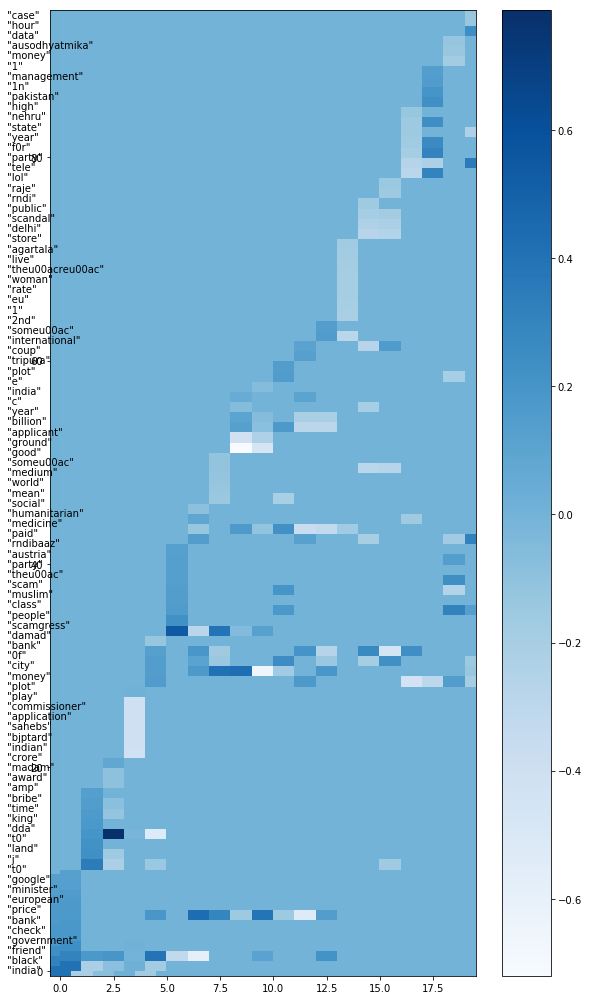

In [19]:
heat_map(lsimodel)

/home/ubuntu/.virtualenvs/psu/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


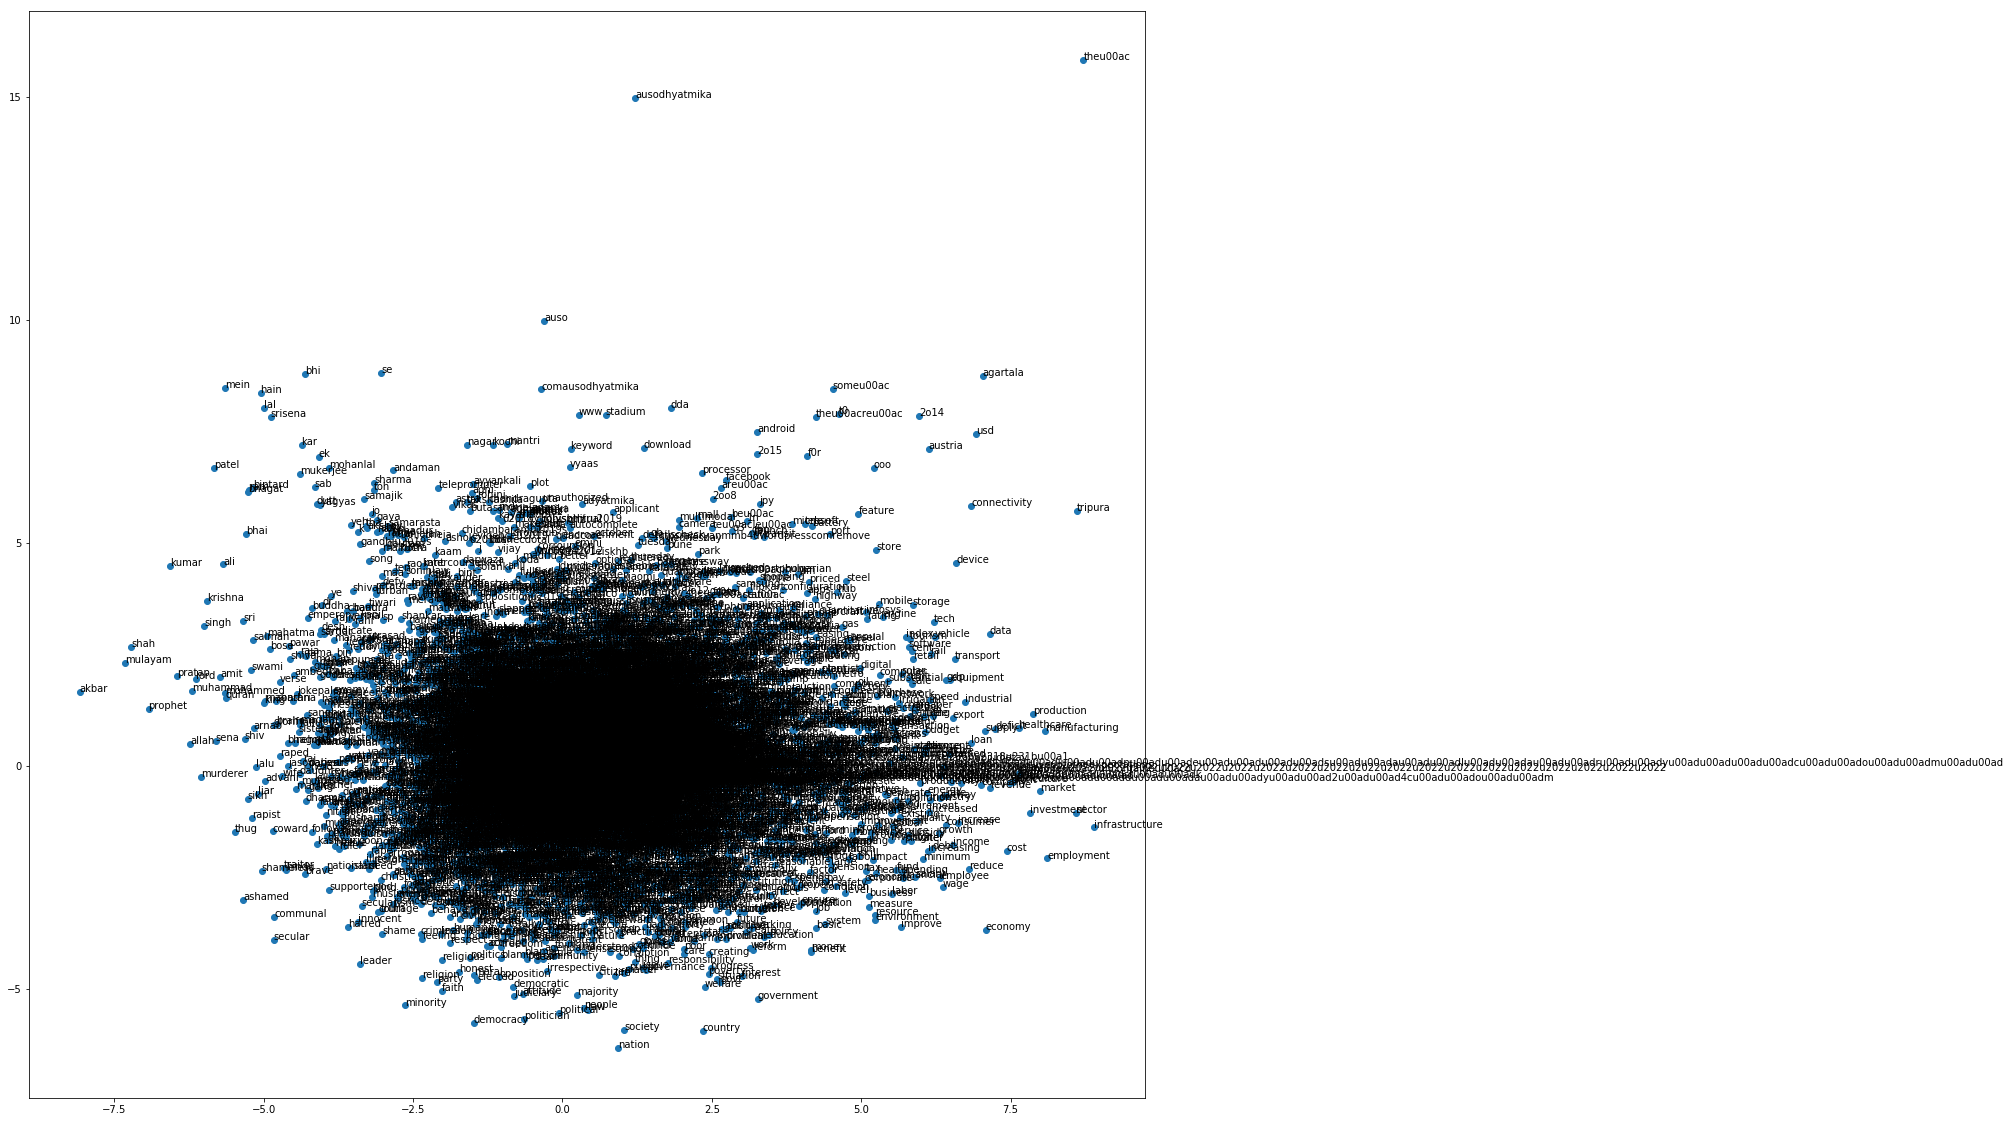

In [20]:
pca_scatter_graph(doc_cleaned)

# <div class="alert alert-block alert-info"><font color='red'> Anonymous user (Positive Comments) </font></div>

In [29]:
# read the document
doc_cleaned = read_document('anony_positivecomment.txt')

Reading Document anony_positivecomment.txt
Document Finished Reading
Document Cleaning Started
Document Cleaning Ended


In [30]:
frequency_doc = frequency_calculate(doc_cleaned)

In [31]:
dictionary, doc_term_matrix = prepare_lda_prerequisite(doc_cleaned)
ldamodel = run_lda(dictionary,doc_term_matrix,20)

In [32]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

/home/ubuntu/.virtualenvs/psu/local/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
14     11.125308        1       1  0.222822 -0.132922
6       9.371189        1       2 -0.127024  0.003314
1       9.228478        1       3  0.074454 -0.017174
3       8.891505        1       4 -0.203909 -0.115562
17      8.528786        1       5 -0.027375 -0.229749
0       6.427577        1       6  0.015684  0.101979
13      6.336030        1       7  0.042267 -0.001842
10      4.839458        1       8 -0.017241  0.102079
11      4.616812        1       9  0.004530  0.050720
16      4.511831        1      10  0.000733 -0.011593
5       3.931685        1      11  0.009790  0.016625
9       3.820656        1      12  0.012277  0.045978
12      3.485601        1      13 -0.014133  0.026826
2       2.856107        1      14 -0.028534 -0.006693
8       2.835193        1      15  0.026845  0.015880
19      2.386453        1      16  0.008304  0.050509
15      2.042474        1      17  0.002274  0.047342
7       1.917377        1      18 -0.004573  0.010787
18      1.717465        1      19  0.006904  0.019634
4       1.130030        1      20 -0.004094  0.023859, topic_info=     Category       Freq             Term      Total  loglift  logprob
term                                                                  
739   Default  19.000000            woman  19.000000  30.0000  30.0000
920   Default  11.000000              sex  11.000000  29.0000  29.0000
259   Default  15.000000            judge  15.000000  28.0000  28.0000
444   Default  11.000000              man  11.000000  27.0000  27.0000
272   Default   7.000000             govt   7.000000  26.0000  26.0000
108   Default   8.000000             bank   8.000000  25.0000  25.0000
283   Default  22.000000           people  22.000000  24.0000  24.0000
433   Default   5.000000          economy   5.000000  23.0000  23.0000
26    Default   6.000000            meizu   6.000000  22.0000  22.0000
820   Default  14.000000             good  14.000000  21.0000  21.0000
1338  Default  15.000000       government  15.000000  20.0000  20.0000
466   Default   7.000000           farmer   7.000000  19.0000  19.0000
801   Default   6.000000              cji   6.000000  18.0000  18.0000
640   Default  12.000000            world  12.000000  17.0000  17.0000
49    Default   5.000000               m1   5.000000  16.0000  16.0000
1304  Default  11.000000          country  11.000000  15.0000  15.0000
1039  Default   5.000000         question   5.000000  14.0000  14.0000
373   Default   5.000000     constitution   5.000000  13.0000  13.0000
64    Default  10.000000             work  10.000000  12.0000  12.0000
624   Default   7.000000            money   7.000000  11.0000  11.0000
31    Default   7.000000              men   7.000000  10.0000  10.0000
116   Default   4.000000             mean   4.000000   9.0000   9.0000
1148  Default   7.000000           native   7.000000   8.0000   8.0000
72    Default  15.000000            india  15.000000   7.0000   7.0000
1071  Default   6.000000             land   6.000000   6.0000   6.0000
1235  Default   6.000000            crore   6.000000   5.0000   5.0000
863   Default   5.000000            story   5.000000   4.0000   4.0000
528   Default   7.000000          channel   7.000000   3.0000   3.0000
480   Default   6.000000             year   6.000000   2.0000   2.0000
82    Default   9.000000              law   9.000000   1.0000   1.0000
...       ...        ...              ...        ...      ...      ...
271   Topic20   0.016047       background   1.022808   0.3281  -7.5730
862   Topic20   0.016047       portraying   1.022808   0.3281  -7.5730
161   Topic20   0.016047          medical   1.022808   0.3281  -7.5730
831   Topic20   0.016047           mental   1.022808   0.3281  -7.5730
1075  Topic20   0.016047         required   1.022808   0.3281  -7.5730
457   Topic20   0.016047          pointed   1.022808   0.3281  -7.5730


In [33]:
lsimodel = run_lsi(doc_term_matrix,dictionary,20)
print_lsi(lsimodel)

(0, u'0.641*"woman" + 0.431*"sex" + 0.326*"man" + 0.213*"men" + 0.188*"child" + 0.124*"year" + 0.122*"cheating" + 0.100*"marriage" + 0.099*"marry" + 0.097*"mother"')
(1, u'-0.520*"bank" + -0.364*"crore" + -0.209*"r" + -0.208*"risk" + -0.171*"issue" + -0.163*"people" + -0.156*"roy" + -0.156*"financial" + -0.107*"capital" + -0.106*"channel"')
(2, u'0.387*"meizu" + 0.339*"m1" + 0.242*"display" + 0.242*"note" + 0.194*"mi4i" + 0.186*"people" + 0.158*"work" + -0.149*"bank" + 0.122*"good" + 0.110*"correct"')
(3, u'0.312*"people" + -0.282*"meizu" + -0.247*"m1" + 0.182*"native" + -0.176*"display" + -0.176*"note" + 0.168*"channel" + 0.154*"work" + -0.141*"mi4i" + -0.135*"bank"')
(4, u'-0.321*"judge" + -0.234*"cji" + -0.223*"letter" + -0.161*"holiday" + -0.157*"good" + -0.149*"communal" + -0.149*"write" + -0.149*"covertly" + -0.149*"christian" + -0.147*"hc"')
(5, u'-0.243*"add" + -0.204*"hc" + -0.176*"law" + -0.158*"true" + -0.154*"constitution" + -0.151*"question" + -0.139*"happen" + -0.137*"cri

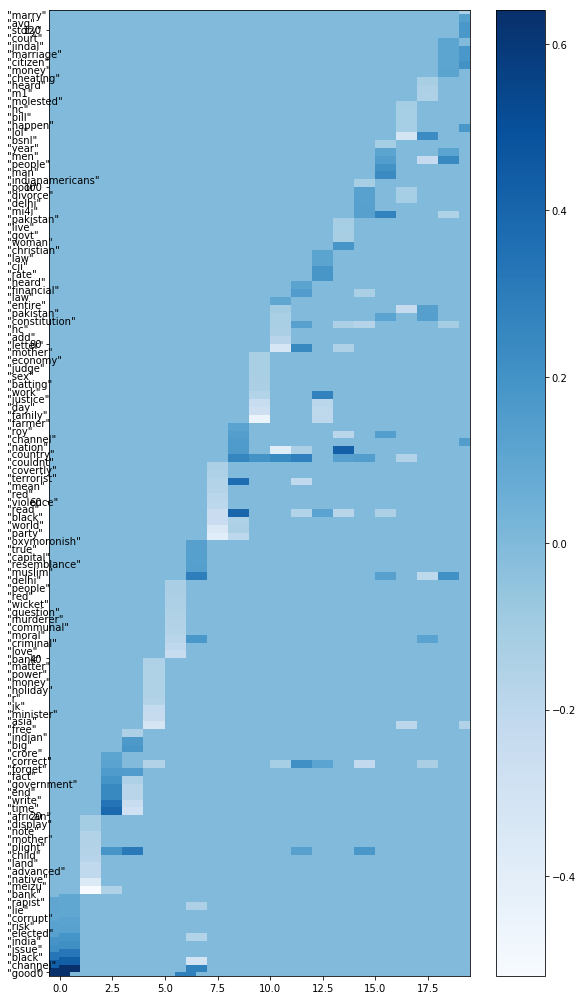

In [34]:
heat_map(lsimodel)

/home/ubuntu/.virtualenvs/psu/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


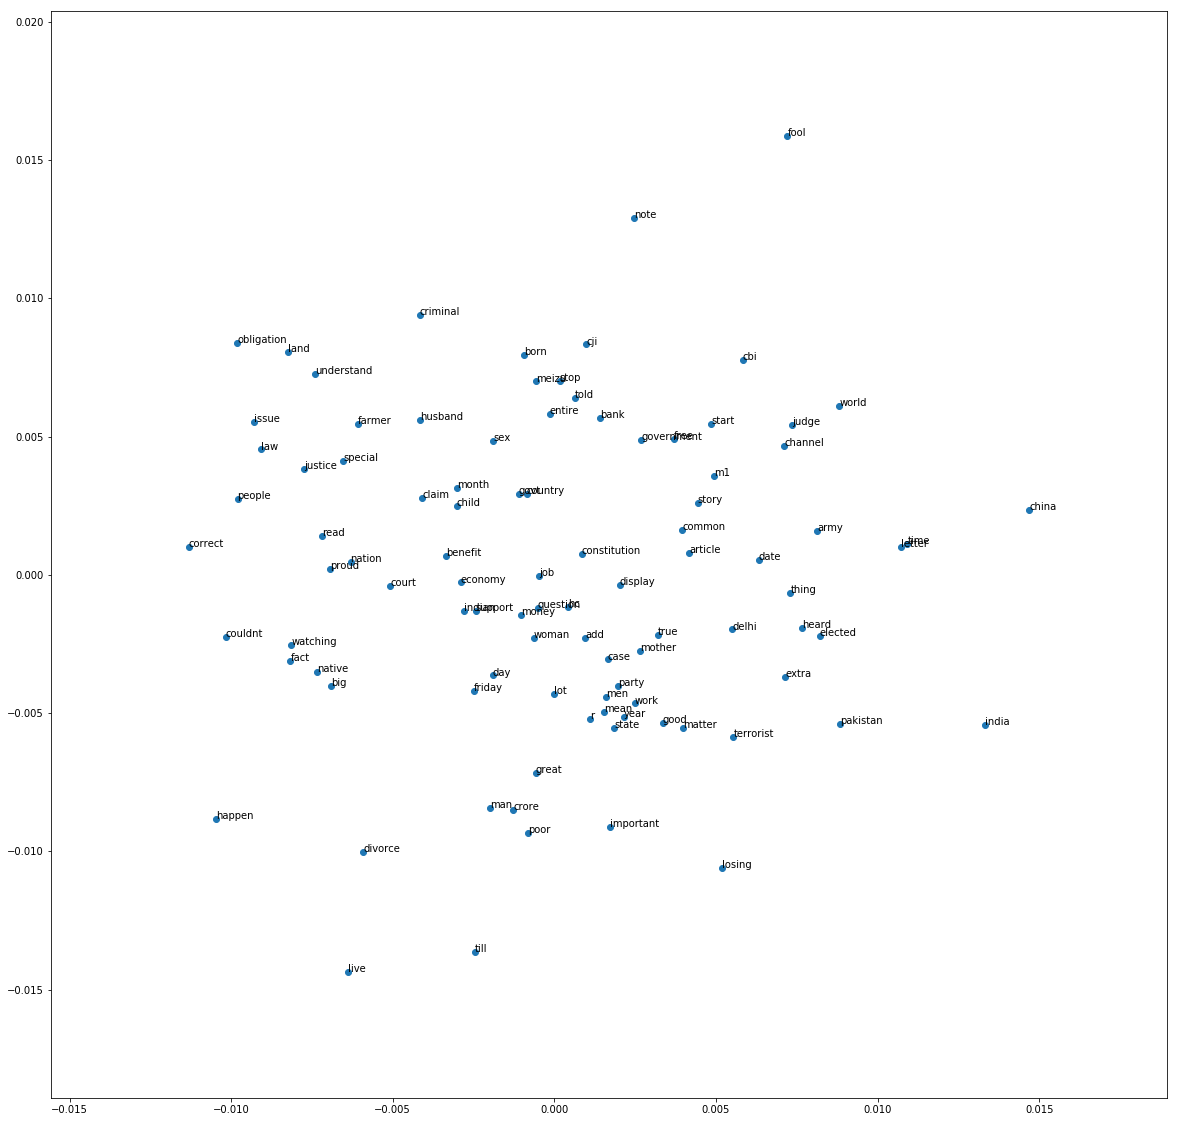

In [35]:
pca_scatter_graph(doc_cleaned)

# <div class="alert alert-block alert-info"><font color='red'> Users with Anonymous profiles (Positive Comments) </font> </div>

In [36]:
# read the document
doc_cleaned = read_document('null_positivecomment.txt')

Reading Document null_positivecomment.txt
Document Finished Reading
Document Cleaning Started
Document Cleaning Ended


In [37]:
frequency_doc = frequency_calculate(doc_cleaned)

In [38]:
dictionary, doc_term_matrix = prepare_lda_prerequisite(doc_cleaned)
ldamodel = run_lda(dictionary,doc_term_matrix)

In [39]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

/home/ubuntu/.virtualenvs/psu/local/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
90     6.096480        1       1  0.003556 -0.214340
70     2.526062        1       2  0.041537 -0.120546
13     1.839879        1       3  0.053226 -0.067509
54     1.714305        1       4 -0.029583 -0.078635
27     1.489599        1       5  0.155381 -0.027827
8      1.441357        1       6  0.083559 -0.059114
86     1.411142        1       7 -0.012902 -0.054863
73     1.390554        1       8  0.027995 -0.068795
22     1.357074        1       9  0.138577 -0.020244
60     1.333636        1      10  0.029393 -0.022898
71     1.303879        1      11  0.058680 -0.041378
56     1.255541        1      12  0.180200  0.105954
94     1.242700        1      13 -0.049782 -0.072871
57     1.239879        1      14 -0.016705 -0.005257
26     1.220895        1      15  0.028987 -0.028015
98     1.211313        1      16  0.035632 -0.010191
0      1.205810        1      17 -0.000805 -0.005290
30     1.204325        1      18  0.009835 -0.039741
55     1.197660        1      19  0.045335  0.170345
93     1.195008        1      20  0.082707 -0.066797
80     1.177395        1      21  0.075202 -0.002724
74     1.159006        1      22  0.024068 -0.010313
29     1.157251        1      23  0.045858  0.015521
28     1.151088        1      24  0.170080  0.082506
20     1.126306        1      25  0.017363 -0.070894
83     1.111006        1      26  0.131745  0.004076
77     1.097414        1      27  0.030841 -0.050242
9      1.093510        1      28 -0.030973 -0.062112
61     1.071228        1      29 -0.004205 -0.036829
79     1.054169        1      30  0.155922  0.071885
...         ...      ...     ...       ...       ...
15     0.775371        1      71 -0.037821 -0.006337
58     0.762265        1      72 -0.059613 -0.005024
39     0.760344        1      73 -0.018111 -0.006831
2      0.752674        1      74  0.027111 -0.019700
42     0.744646        1      75  0.034818  0.047005
24     0.737584        1      76 -0.035930 -0.000067
49     0.736721        1      77 -0.044200  0.000020
97     0.736109        1      78 -0.048317  0.028783
52     0.734581        1      79 -0.079282 -0.000636
18     0.733699        1      80  0.000244  0.005578
91     0.731087        1      81 -0.031271  0.029666
87     0.723820        1      82 -0.041337 -0.032422
6      0.712157        1      83 -0.035478  0.052857
76     0.704017        1      84 -0.005972  0.034941
65     0.691573        1      85 -0.027505 -0.005384
31     0.670189        1      86 -0.044737  0.065036
38     0.660535        1      87 -0.046301  0.039359
5      0.659949        1      88 -0.064446  0.005757
50     0.658976        1      89 -0.015452  0.091591
23     0.652383        1      90 -0.020746  0.001079
88     0.651790        1      91 -0.047712 -0.031768
40     0.607001        1      92 -0.032655  0.079153
67     0.588962        1      93  0.005268  0.091977
33     0.586747        1      94 -0.049381 -0.009939
63     0.573098        1      95 -0.090756  0.058538
96     0.559441        1      96 -0.081333  0.059027
69     0.530734        1      97 -0.085968  0.058364
19     0.525594        1      98 -0.040918  0.041324
34     0.520784        1      99 -0.066414  0.096290
3      0.458329        1     100 -0.080456  0.002148

[100 rows x 5 columns], topic_info=       Category        Freq        Term       Total  loglift  logprob
term                                                                 
6553    Default  629.000000       party  629.000000  30.0000  30.0000
6437    Default  129.000000    recently  129.000000  29.0000  29.0000
1499    Default  122.000000     engaged  122.000000  28.0000  28.0000
1646    Default  145.000000     tripura  145.000000  27.0000  27.0000
7808    Default  140.000000      making  140.000000  26.0000  26.0000
11798   Default  279.000000       delhi  279.000000  25.0000  25.0000
882     Default  456.000000       

In [40]:
lsimodel = run_lsi(doc_term_matrix,dictionary,20)
print_lsi(lsimodel)

(0, u'0.467*"tripura" + 0.256*"agartala" + 0.196*"india" + 0.195*"class" + 0.192*"world" + 0.187*"state" + 0.169*"city" + 0.149*"international" + 0.144*"hour" + 0.134*"people"')
(1, u'-0.511*"party" + -0.339*"people" + -0.249*"india" + -0.211*"country" + -0.161*"time" + -0.158*"indian" + -0.153*"delhi" + 0.149*"tripura" + -0.132*"political" + -0.129*"good"')
(2, u'0.667*"party" + -0.365*"india" + -0.177*"indian" + -0.175*"people" + -0.171*"land" + -0.166*"country" + 0.109*"delhi" + 0.094*"tripura" + 0.091*"political" + -0.089*"rule"')
(3, u'-0.370*"electricity" + -0.339*"rule" + -0.296*"consumer" + -0.287*"court" + -0.190*"act" + -0.176*"ombudsman" + -0.175*"regular" + 0.172*"people" + -0.172*"discoms" + -0.152*"recruitment"')
(4, u'0.323*"country" + -0.303*"india" + -0.294*"ji" + -0.242*"kargil" + 0.234*"people" + -0.207*"vajpayee" + -0.167*"ratna" + -0.163*"deserves" + -0.162*"pakis" + -0.123*"indian"')
(5, u'-0.649*"country" + 0.429*"people" + 0.181*"land" + -0.114*"ji" + -0.113*"co

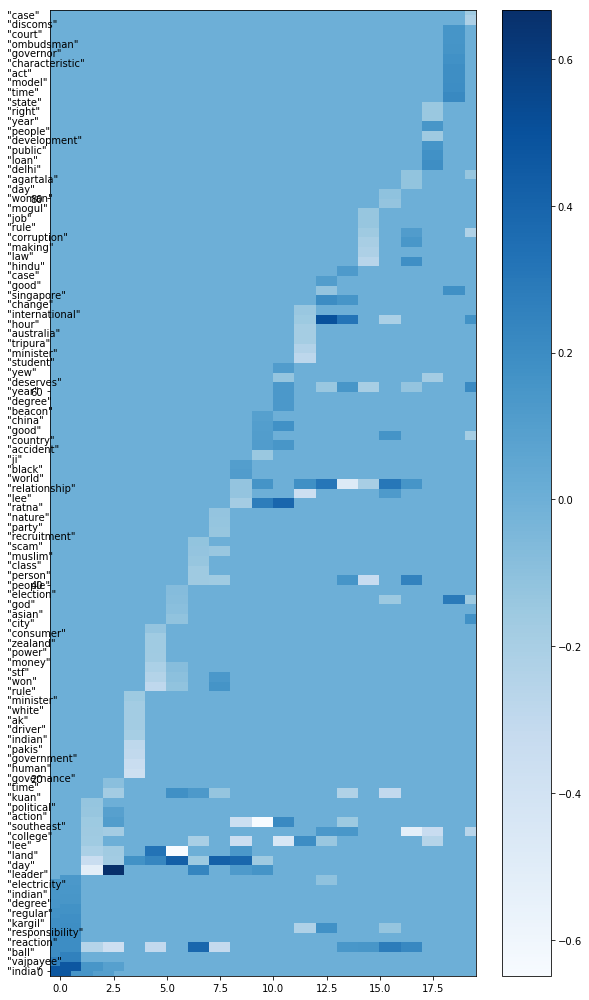

In [41]:
heat_map(lsimodel)

/home/ubuntu/.virtualenvs/psu/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


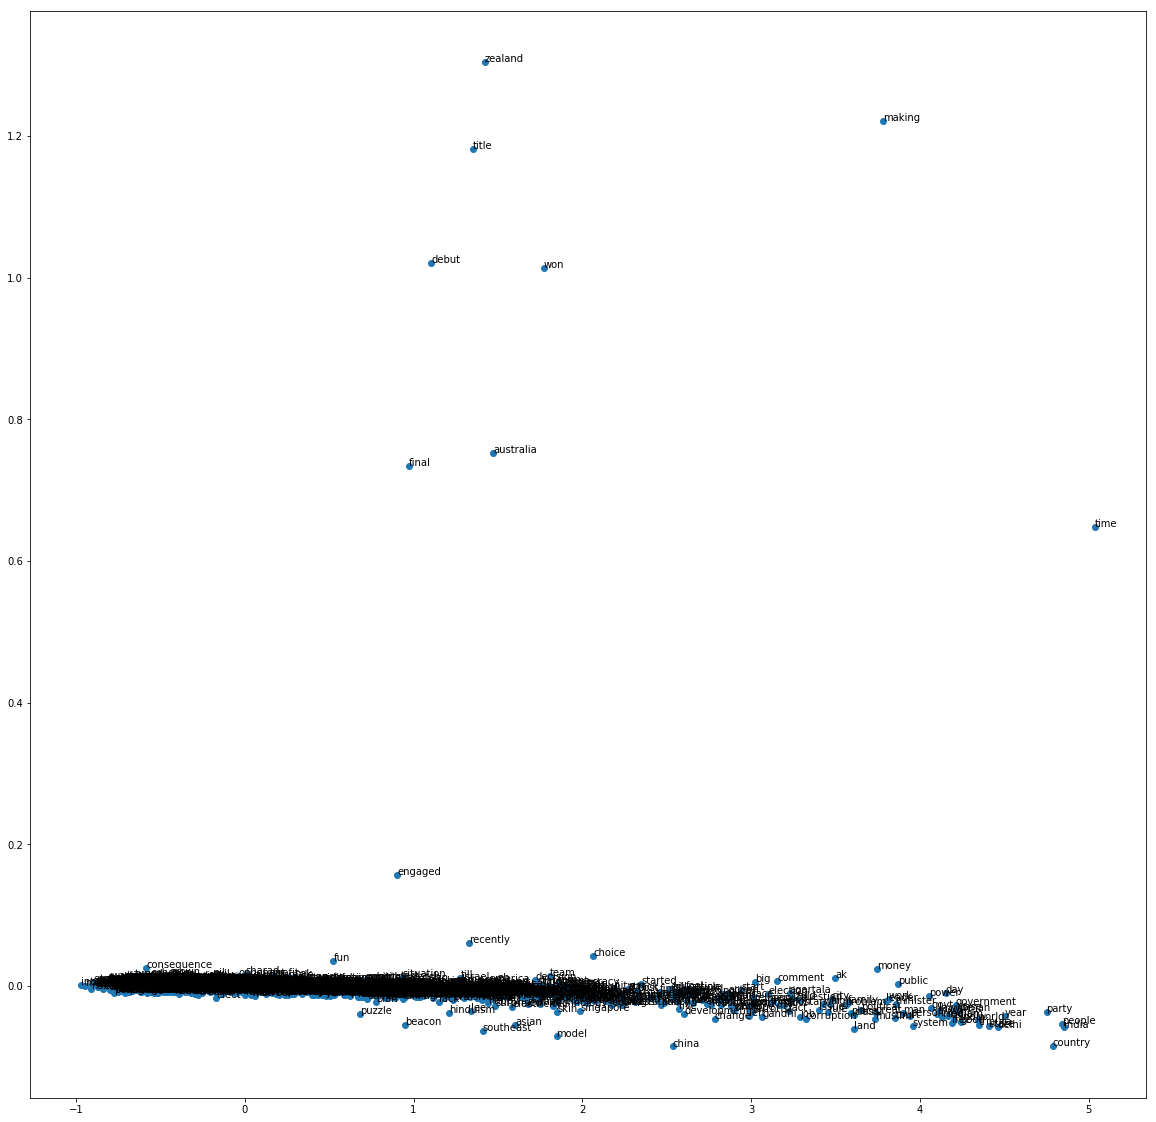

In [42]:
pca_scatter_graph(doc_cleaned)